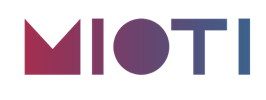
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Machine Learning</center>
<center style="color:#aaa; margin-top:10px;">Prof. Diego García Morate<br>diegogm@faculty.mioti.es</center>

# Worksheet S6: Escalado de los datos y SVM

## Objetivos

Los objetivos de este worksheet son:
* que aprendas técnicas de escalado de los datos que te ayudarán a preparar los datos de una manera más acorde a como lo esperan los algoritmos.
* que conozcan las máquinas de vectores soporte (SVM)

## Configuración del entorno

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

También vamos a cargar algunas funciones que nos resultarán interesantes.

In [2]:
def plot_2d_separator(classifier, X, y, fill=False, ax=None, eps=None):
    from matplotlib.colors import ListedColormap
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:,0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
    
    if eps is None:
        eps = X.std() / 2.
    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0]
        fill_levels = [decision_values.min(), 0, decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5]
        fill_levels = [0, .5, 1]

    if ax is None:
        ax = plt.gca()

    ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels, colors="black")

In [3]:
def dibuja_dataset(X, y):  
    from matplotlib.colors import ListedColormap
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:,0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')

In [4]:
def eval_scaler(scaler, X, y):
    scaler.fit(X)
    scaled_X = scaler.transform(X)
    dibuja_dataset(scaled_X, y)
    return scaled_X

## Dataset

Como en otras ocasiones vamos a generar un dataset ficticio:

In [5]:
from sklearn.datasets import make_moons
dataset = make_moons(noise=0.7, random_state=10)

In [9]:
dataset_X = dataset[0]
dataset_X += 10

In [10]:
dataset_y = dataset[1]

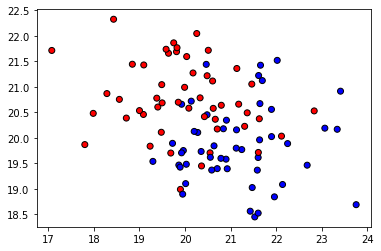

In [11]:
dibuja_dataset(dataset_X, dataset_y)

In [38]:
dataset_X.shape
dataset_y.shape

(100,)

## Escalado de los datos

Como vimos en la clase anterior, no podemos comparar "peras con manzanas" y muchos algoritmos de aprendizaje automático, asumen o mejoran sensiblemente, si los datos están correctamente escalados.

Los escalados más habituales, y disponibles en `sklearn` son:

### `StandardScaler`

Estandariza los datos para conseguir que su media ($\mu$) sea 0 y su varianza ($\sigma$) 1.

$$x_{standardized} = \frac{x - \mu}{\sigma}$$

array([[-1.20081660e+00,  1.66996616e-01],
       [-7.50158456e-01,  1.54820937e+00],
       [-9.42476028e-01,  3.34269255e-01],
       [-3.95959545e-03, -6.99121008e-01],
       [ 1.38867035e+00, -4.90221727e-01],
       [-1.57305726e-01, -9.95132661e-01],
       [ 7.99092622e-01, -2.14547574e+00],
       [-1.73665124e+00,  2.31614953e+00],
       [-1.27160779e+00,  2.54426233e-01],
       [ 2.83247876e-01, -8.41990605e-01],
       [-7.09284821e-01, -7.03802113e-01],
       [ 1.86651649e+00,  2.47314359e-01],
       [ 5.65352910e-01, -6.25433635e-01],
       [-7.24638622e-02,  1.29789895e+00],
       [ 1.10035634e+00, -3.32366502e-01],
       [-6.78202006e-01, -4.84584254e-01],
       [ 2.27993134e+00, -1.67649384e-01],
       [-9.60858348e-01,  5.34791218e-01],
       [-1.03064043e+00, -8.91971338e-01],
       [-1.50767046e+00,  8.56430192e-02],
       [ 9.34761380e-01,  9.31764083e-01],
       [-4.83907463e-01, -6.47325664e-01],
       [-1.64096386e-01, -6.68542608e-01],
       [-2.

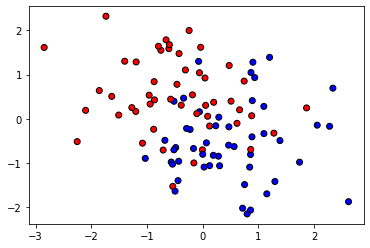

In [12]:
from sklearn.preprocessing import StandardScaler

eval_scaler(StandardScaler(), dataset_X, dataset_y)

### `MinMaxScaler`

Ajusta los datos para fijar los datos a un rango dado (por defecto $[0,1]$). La transformación que aplica es la siguiente:

``
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) # Convierte el rango de la función a [0, 1]
X_scaled = X_std * (max - min) + min # Reescala al rango dado
``

array([[0.60206787, 1.03660537],
       [0.7669452 , 1.65575766],
       [0.69658409, 1.1115882 ],
       [1.03994877, 0.6483533 ],
       [1.54945496, 0.74199598],
       [0.98384571, 0.515661  ],
       [1.33375265, 0.        ],
       [0.40602795, 2.        ],
       [0.57616828, 1.07579719],
       [1.14502621, 0.58430955],
       [0.78189919, 0.64625491],
       [1.72427927, 1.07260917],
       [1.24823687, 0.68138493],
       [1.01488587, 1.54355173],
       [1.44397269, 0.81275729],
       [0.79327112, 0.74452308],
       [1.87553081, 0.88659456],
       [0.68985875, 1.2014756 ],
       [0.66432835, 0.56190483],
       [0.48980263, 1.00013722],
       [1.38338828, 1.37942549],
       [0.86435553, 0.67157145],
       [0.98136128, 0.66206059],
       [0.27237819, 1.04773045],
       [1.35051346, 0.4734101 ],
       [0.91626098, 1.17123657],
       [0.87274909, 1.31125552],
       [0.95895916, 0.85436142],
       [1.21587269, 1.5017675 ],
       [1.02037682, 1.03342559],
       [0.

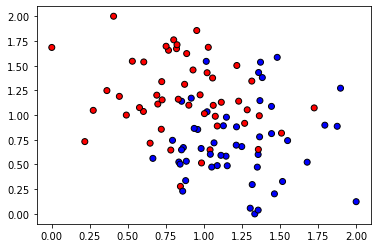

In [13]:
from sklearn.preprocessing import MinMaxScaler

eval_scaler(MinMaxScaler((0, 2)), dataset_X, dataset_y)

### `RobustScaler`

Similar al `StandarScaler` pero en vez de utilizar la media, se utiliza la mediana y en vez de la varianza el rango intercuartilico.

array([[-0.86961498,  0.08804133],
       [-0.53019074,  1.10946083],
       [-0.67503944,  0.21174098],
       [ 0.03182723, -0.5524606 ],
       [ 1.08072063, -0.39797766],
       [-0.08366917, -0.77136393],
       [ 0.63666571, -1.62205319],
       [-1.27319198,  1.67735962],
       [-0.9229331 ,  0.15269633],
       [ 0.24814459, -0.65811398],
       [-0.49940576, -0.55592232],
       [ 1.44062218,  0.14743703],
       [ 0.46061891, -0.49796811],
       [-0.01976843,  0.92435398],
       [ 0.86356987, -0.28124228],
       [-0.47599498, -0.3938087 ],
       [ 1.75199571, -0.15943246],
       [-0.68888453,  0.36002881],
       [-0.74144262, -0.69507519],
       [-1.10072949,  0.0278796 ],
       [ 0.73884796,  0.65359388],
       [-0.32965728, -0.51415747],
       [-0.08878372, -0.52984759],
       [-1.54832966,  0.10639444],
       [ 0.6711703 , -0.84106552],
       [-0.22280227,  0.31014328],
       [-0.31237789,  0.54113344],
       [-0.13490178, -0.21260768],
       [ 0.3939925 ,

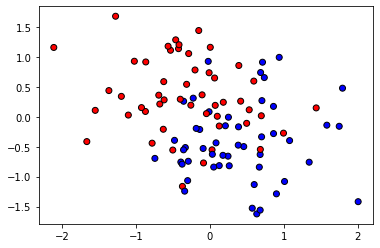

In [14]:
from sklearn.preprocessing import RobustScaler

eval_scaler(RobustScaler(), dataset_X, dataset_y)

### `Normalizer`

normaliza cada instancia individualmente para que tengan como norma (L1 o L2) la unidad. Por defecto, se utiliza L2.

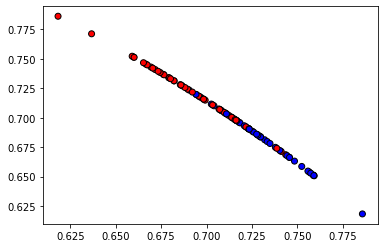

In [16]:
from sklearn.preprocessing import Normalizer

scaled_X = eval_scaler(Normalizer(norm='l2'), dataset_X, dataset_y)

In [17]:
dataset_X[0]

array([19.08636394, 20.45882328])

In [18]:
scaled_X[0]

array([0.68215515, 0.73120746])

### Comparativa

Podemos ver todos los resultados juntos y compararlos:

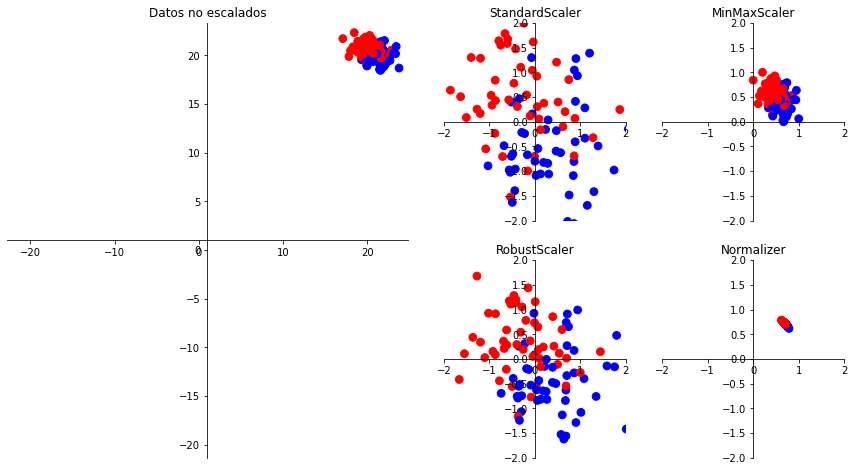

In [19]:
plt.figure(figsize=(15, 8))
main_ax = plt.subplot2grid((2, 4), (0, 0), rowspan=2, colspan=2)

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
main_ax.scatter(dataset_X[:, 0], dataset_X[:, 1], c=dataset_y, cmap=cm_bright, s=60)
maxx = np.abs(dataset_X[:, 0]).max()
maxy = np.abs(dataset_X[:, 1]).max()

main_ax.set_xlim(-maxx + 1, maxx + 1)
main_ax.set_ylim(-maxy + 1, maxy + 1)
main_ax.set_title("Datos no escalados")
other_axes = [plt.subplot2grid((2, 4), (i, j)) for j in range(2, 4) for i in range(2)]

for ax, scaler in zip(other_axes, [StandardScaler(), RobustScaler(),
                                   MinMaxScaler(), Normalizer(norm='l2')]):
    X_ = scaler.fit_transform(dataset_X)
    ax.scatter(X_[:, 0], X_[:, 1], c=dataset_y, cmap=cm_bright, s=60)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_title(type(scaler).__name__)

other_axes.append(main_ax)

for ax in other_axes:
    ax.spines['left'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('center')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

### Resumen

A continuación se enumeran algunas ventajas (➕) e inconvenientes de cada uno de los algoritmos (➖):

#### StandardScaler

* (➕) Eficiente de calcular, requiere sólo de calcular la media y desviación de típica.
* (➕) No modifica la forma de los datos 
* (➖) Es sensible a outliers. 

#### MinMaxScaler

* (➕) Eficiente de calcular, requiere sólo del máximo y del mínimo.
* (➕) No modifica la forma de los datos 
* (➖) Es muy sensible a outliers (basta con que haya 1 outlier para sesgar el resultado).

#### RobustScaler

* (➖) No muy eficiente de calcular (requiere meter todos los datos en memoria y ordenarlos).
* (➕) No modifica la forma de los datos 
* (➕) Es robusto frente a outliers.

#### Normalizer

* (➕) Eficiente de calcular, no requiere datos en memoria.
* (❓) Modifica la forma de los datos. 
* (➖) No es robusto frente a outliers.



### Preguntas

* ¿Cuál es el mejor método de escalado?
* ¿Por qué debemos de escalar?

## Conjunto de entrenamiento y de test

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, test_size=.3, random_state=42)

## SVM

Las máquinas de vector soporte (SVM) han sido uno de los clasificadores más utilizados en los últimos años. Combinan buenos resultados, con un tiempo de entrenamiento muy bueno. Mucha gente las categoriza como un clasificador independiente a los ya vistos aunque, como veremos, realmente son un subtipo de un perceptrón multicapa.

Una máquina vector soporte es un perceptrón multicapa con dos capas y una función de activación sigmoide que como ya vimos nos permite incorporar no linearidad de manera que conseguimos "remappear" los datos a un espacio dimensional superior.

<img src="svm_remapping.jpg">

Además de esto, las SVM, trabajan con una función de pérdida distinta.

### Una función de pérdida con margen

Si en la clase anterior veíamos la función de pérdida `softmax` que tenía la siguiente pinta:

$$ L_i = -log(\frac{e^{sy_i}}{\sum_j e^{S_j}}) $$

En las máquinas de vector soporte utilizamos una función de pérdida distinta:

$$ L_i = \sum_{j \ne y_i} max(0, S_j - S_{y_i} + 1) $$

donde $S_{y_i}$ es el valor de la clase real

Supongamos que tenemos un clasificador que devuelve como resultado:

$$
\left( \begin{array}{cc}
Perro \\
Gato \\
Pájaro
\end{array} \right)
=
\left( \begin{array}{cc}
3.2 \\
5.1 \\
-1.7
\end{array} \right)
$$

La clase real es **Perro**. La función de pérdida la podemos calcular como:

$$L_i = max(0, 5.1 - 3.2 + 1) + max(0, -1.7 - 3.2 + 1)$$
$$L_i = max(0, 2.9) + max(0, -3.9)$$
$$L_i = 2.9 + 0$$
$$L_i = 2.9$$

Desde un punto de vista práctico, lo que buscan las SVM es generar una separación entre ambos conjuntos dejando un margen entre ellos.

<img src="svm_hiperplano.jpg">

#### Preguntas

* ¿Qué hace esta función de pérdida?
* ¿Cuál es la situación que minimiza la pérdida? ¿Cuál es la que lo maximiza?

### SVM en `sklearn`

Las SVM están disponibles, además de como máquinas de regresión, como clasificadores en `sklearn`.

In [21]:
from sklearn.svm import SVC
clf = SVC()

In [22]:
clf.fit(X_train, y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

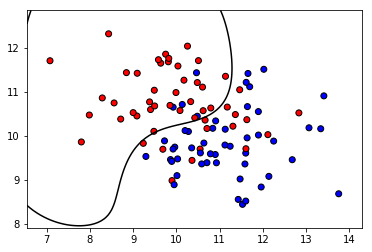

In [19]:
plot_2d_separator(clf, dataset_X, dataset_y)

In [39]:
clf = SVC(C=1.0)

In [40]:
clf.fit(X_train, y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

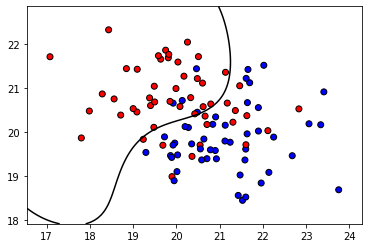

In [41]:
plot_2d_separator(clf, dataset_X, dataset_y)